In [1]:
#!pip install langdetect
#!pip install pyLDAvis
#!pip install spacy==3.0.5
#!pip install spacy-spanish-lemmatizer==0.6
#!spacy download es_core_news_sm
#!python3 -m spacy_spanish_lemmatizer download wiki

import langdetect  # language detection
import nltk  # natural language processing
from nltk.corpus import words
from nltk.stem.wordnet import WordNetLemmatizer
import pyLDAvis  # plotting
import pyLDAvis.sklearn  # plotting
import sklearn  # machine learning
import numpy  # arrays and matrices
import pandas  # dataframes
import regex  # regular expressions
import string
from unicodedata import normalize
import spacy
import spacy_spanish_lemmatizer
from html import unescape
from numbers import Number
from joblib import Parallel, delayed
from pytictoc import TicToc
tictoc = TicToc()

# added to suppress warnings coming from pyLDAvis
import warnings
warnings.filterwarnings('ignore')

/home/alexander/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [2]:
# installing specific word dictionarys
# used for stopword removal and lemmatization

nltk.download("words")
nltk.download("wordnet")
nltk.download("stopwords")

nlp = spacy.load("es_core_news_sm")
nlp.replace_pipe("lemmatizer", "spanish_lemmatizer")

stopwords = set(pandas.read_csv("stopwords/stopwords.csv").word.tolist())
stopwords = set([i for i in stopwords if type(i) == str])
print(f'Cantidad de stopwords: {len(stopwords)}')

[nltk_data] Downloading package words to /home/alexander/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/alexander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Cantidad de stopwords: 608


In [4]:
path = 'agregado_vacantes_scraping_20210712.xlsx'
df = pandas.read_excel(path)
df = df.drop_duplicates()
df = df[['Cargo','Descripcion','Educacion requerida','Experiencia requerida (meses)','Tipo de empleo','Empresa','Sector',
         'Cantidad de aplicantes','Fecha de publicacion','Fecha de expiracion','Ciudad','Pais']]
print("SHAPE:\n{shape}\n".format(shape=df.shape))
print("COLUMN NAMES:\n{names}\n".format(names=df.columns.tolist()))
df.head()

SHAPE:
(2613, 12)

COLUMN NAMES:
['Cargo', 'Descripcion', 'Educacion requerida', 'Experiencia requerida (meses)', 'Tipo de empleo', 'Empresa', 'Sector', 'Cantidad de aplicantes', 'Fecha de publicacion', 'Fecha de expiracion', 'Ciudad', 'Pais']



,Cargo,Descripcion,Educacion requerida,Experiencia requerida (meses),Tipo de empleo,Empresa,Sector,Cantidad de aplicantes,Fecha de publicacion,Fecha de expiracion,Ciudad,Pais
0,DevOps Senior Engineer,&lt;p&gt;&lt;strong&gt;Position Overview&lt;/s...,bachelor degree,72.0,FULL_TIME,Qual.IT,NaN,NaN,2021-07-12T18:58:44.000Z,2021-08-11T18:58:44.000Z,Medellín,CO
1,Asesor Comercial experiencia en Belleza,Importante empresa esta solicitando Asesor Com...,bachelor degree,NaN,FULL_TIME,reclutapro.com,"Marketing y publicidad,Servicios y tecnologías...",NaN,2021-07-07T10:27:59.000Z,2021-08-06T10:27:59.000Z,Medellín,CO
2,Ejecutivo de Ventas - Writing,&lt;strong&gt;Position: &lt;/strong&gt;Ejecuti...,NaN,NaN,FULL_TIME,Newell Brands,Artículos de consumo,NaN,2021-07-12T22:35:42.000Z,2021-08-11T22:35:41.000Z,Medellín,CO
3,Desarrollador de Android,Buscamos profesionales en ingeniería de sistem...,bachelor degree,NaN,OTHER,NAPOLEON SYSTEMS,NaN,NaN,2021-07-08T19:56:46.000Z,2021-08-07T19:56:46.000Z,Medellín,CO
4,Analista de Estrategia y Planeación de Rutas,&lt;p&gt;Nos encontramos en la búsqueda de un ...,bachelor degree,NaN,FULL_TIME,Viva,Aeronáutica/Aviación,174 solicitudes,2021-07-06T22:47:27.000Z,2021-08-05T22:47:26.000Z,Medellín,CO


In [5]:
# data set came with prespecified topics
# print the topics out with counts

print("TOPICS:\n{topics}\n".format(topics=df["Cargo"].value_counts()))

TOPICS:
Lead DevOps Engineer                                                                53
Middle DevOps Engineer                                                              43
Senior DevOps Engineer                                                              36
Senior Automation Tester                                                            35
Senior JavaScript Developer                                                         28
                                                                                    ..
Product Designer                                                                     1
Sports Technology Customer Success Manager - LATAM - Bilingual Spanish / English     1
Web Engineering Manager                                                              1
Vendedor cajero                                                                      1
Practicante de IngenierÃ­a en sistemas                                               1
Name: Cargo, Length: 743, dtype: in

In [11]:
# view final data that will be carried forward

jobs = df['Cargo'].tolist()
sectors = df['Sector'].tolist()
descriptions = df['Descripcion'].tolist()
print("JOBS:\n{lines}\n".format(lines=jobs[1]))
print("SECTORS:\n{lines}\n".format(lines=sectors[1]))
print("DESCRIPTIONS:\n{lines}\n".format(lines=descriptions[1]))

JOBS:
Asesor Comercial experiencia en Belleza

SECTORS:
Marketing y publicidad,Servicios y tecnologías de la información ,Recursos humanos

DESCRIPTIONS:
Importante empresa esta solicitando Asesor Comercial experiencia en Belleza, experiencia en ventas en el sector retail Horarios: Domingo a domingo turnos rotativos, día compensatorio entre semana. Salario Mínimo legal vigente + auxilio de transporte + prestaciones de ley. Disponibilidad para viajar: Si&lt;br&gt;Disponibilidad para cambio de residencia: Si



In [18]:
# check language of headline, filter to spanish only
def do_language_identif(txt):
    lg = 'none'
    try: lg = langdetect.detect(txt)
    except: pass
    if lg != 'es': return ''
    return txt

def do_clean_html(txt):
    cleantxt = unescape(str(txt))
    cleanr = regex.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return regex.sub(cleanr, ' ', cleantxt)

def do_clean_stopwords(txt):
    out = [t for t in txt.split(" ") if t.lower() not in stopwords]
    return " ".join(out)

# define function to cleaning data
def do_clean_text(txt):
    txt = txt.lower()
    
    # Remove text in square brackets, remove punctuation and remove words containing numbers.
    txt = txt.replace("ñ", "nh")
    txt = regex.sub(r"\[.*?¿\]\%", " ", txt)
    txt = regex.sub(r"https://", "", txt)
    txt = regex.sub(r"www.", "", txt)
    txt = regex.sub(r"[‘’“”…«»]", "", txt)
    txt = regex.sub(r'["\[\]\{\}]', "", txt)
    txt = regex.sub(r"_", " ", txt)
    txt = regex.sub(r"[%s]" % regex.escape(string.punctuation), " ", txt)
    txt = regex.sub(r"\w*\d\w*", "", txt)
    txt = regex.sub(
        r"([^n\u0300-\u036f]|n(?!\u0303(?![\u0300-\u036f])))[\u0300-\u036f]+", r"\1", 
        normalize("NFD", txt), 0, regex.I
    )
    txt = regex.sub(r"\n", " ", txt)
    txt = regex.sub(r"&lt;/?.*?&gt;", " &lt;&gt; ", txt)

    # Eliminar caracteres que se repitan más de dos veces seguidas
    pattern = regex.compile(r"(.)\1{2,}")
    txt = pattern.sub(r"\1\1", txt)
    
    return txt.strip(' ')

# define function to perform lemmatization
def do_lemmatizing(txt):
    out = [word.lemma_ for word in nlp(txt)]
    return out

def do_clean_blanks(tokens):
    tokens = [str(i).strip(' ') for i in tokens]
    return tokens

# define function to execute pipeline pre-processing
def do_prepare_pipeline(element, pipeline):
    inout_data = element if not isinstance(element, Number) else str(element)
    for transform in pipeline:
        inout_data = transform(inout_data)
    return inout_data if inout_data and len(inout_data) > 0 else None

# define pipeline to text pre-processing
pipeline = [
    do_clean_html, 
    do_clean_text,
    do_clean_stopwords,
    do_lemmatizing,
    do_clean_blanks
]

print(do_prepare_pipeline(jobs[1], pipeline), 
do_prepare_pipeline(sectors[1], pipeline),
do_prepare_pipeline(descriptions[1], pipeline))

['asesor', 'comercial', 'experiencia', 'belleza'] ['marketing', 'publicidad', 'servicio', 'tecnologias', 'informacion', '', 'recursos', 'humano'] ['importante', 'empresa', 'solicitar', 'asesor', 'comercial', 'experiencia', 'belleza', '', 'experiencia', 'venta', 'sector', 'retail', 'horario', '', 'domingo', 'domingo', 'turno', 'rotativo', '', 'dia', 'compensatorio', 'semana', '', 'salario', 'minimo', 'legal', 'vigente', '', 'auxilio', 'transporte', '', 'prestación', 'ley', '', 'disponibilidad', 'viajar', '', 'disponibilidad', 'cambio', 'residencia']


In [19]:
# apply cleaning function to every vacancy
#clean = list(map(do_text_cleaning, raw))
tictoc.tic()
clean_jobs = Parallel(n_jobs=24)(delayed(do_prepare_pipeline)(txt, pipeline) for txt in jobs)
clean_sectors = Parallel(n_jobs=24)(delayed(do_prepare_pipeline)(txt, pipeline) for txt in sectors)
clean_descriptions = Parallel(n_jobs=24)(delayed(do_prepare_pipeline)(txt, pipeline) for txt in descriptions)
tictoc.toc('Elapsed time')

Elapsed time 2351.675594 seconds.


In [20]:
# remove none types
#clean_jobs = list(filter(None.__ne__, clean_jobs))
#clean_sectors = list(filter(None.__ne__, clean_sectors))
#clean_descriptions = list(filter(None.__ne__, clean_descriptions))
#print("CLEAN JOBS:\n{lines}\n".format(lines=clean_jobs[1]))
#print("CLEAN SECTORS:\n{lines}\n".format(lines=clean_sectors[1]))
#print("CLEAN DESCRIPTIONS:\n{lines}\n".format(lines=clean_descriptions[1]))

In [21]:
# turn tokens back into strings
# concatenate using whitespaces
clean_jobs_s = [" ".join(i) for i in clean_jobs]
clean_sectors_s = [" ".join(i) for i in clean_sectors]
clean_descriptions_s = [" ".join(i) for i in clean_descriptions]
print("CLEAN JOBS:\n{lines}\n".format(lines=clean_jobs_s[1]))
print("CLEAN SECTORS:\n{lines}\n".format(lines=clean_sectors_s[1]))
print("CLEAN DESCRIPTIONS:\n{lines}\n".format(lines=clean_descriptions_s[1]))

CLEAN JOBS:
asesor comercial experiencia belleza

CLEAN SECTORS:
marketing publicidad servicio tecnologias informacion  recursos humano

CLEAN DESCRIPTIONS:
importante empresa solicitar asesor comercial experiencia belleza  experiencia venta sector retail horario  domingo domingo turno rotativo  dia compensatorio semana  salario minimo legal vigente  auxilio transporte  prestación ley  disponibilidad viajar  disponibilidad cambio residencia



In [23]:
# save to backup data cleaned
clean_sentences = zip(clean_jobs_s, clean_sectors_s, clean_descriptions_s)
clean_df = pandas.DataFrame(data=clean_sentences, columns=["job", "sector", "description"])
clean_df.to_csv("clean_vacancies_tomas.csv", index=False)

### Count Vectorizer

In [35]:
# define some global variables
number_words = 10
number_docs = 10

# load data cleaned
clean_df = pandas.read_csv("clean_vacancies_tomas.csv")
clean_df.fillna('', inplace=True)
clean_df['data'] = clean_df.apply(
    lambda row: '{0} {1} {2}'.format(
        row["job"],
        row["sector"],
        row["description"]
    ).strip(' '),
    axis=1
)
clean_sentences = clean_df.data.tolist()


# Clean data with anothers stopwords
other_stopwords = nltk.corpus.stopwords.words("english") + \
                  ['as', 'middle']

other_mappings =  dict({'dotacia³n':'dotacion','softwar':'software','seleccia³n':'seleccion',
                        'tecnologa':'tecnologias','informacia³n':'informacion'})

def do_clean_others_stopwords(txt):
    out = [t.strip(' ') for t in txt.split(" ") if t not in other_stopwords]
    return " ".join(out)

def do_clean_others_mappings(txt):
    out = [other_mappings.get(t,t).strip(' ') for t in txt.split(" ")]
    return " ".join(out)

#do_clean_others_mappings("applicant comunicacia³n gestia³n informacia³n job experiencia venta retail")

clean_sentences = list(map(do_clean_others_stopwords, clean_sentences))
clean_sentences = list(map(do_clean_others_mappings, clean_sentences))
clean_sentences[:1]

['devops senior engineer  position overview  looking senior devops join rapidly growing development team  applicant mix deep technical skills together excellent client facing consulting communication skills  responsible delivering high quality solutions  position individual pro activar  ambitious eager succeed become part rapidly growing company   like building modern reliable production systems  years experience taught anyone could write code  writing code others understand art value  youre curious  know making mistakes one gains experience  like challenge challenger  opened change enjoy exploring uncharterer territories  get things donar  focus things matter like see tangible progress  team player  know lot  work english clients development team  work remotely days  least one day week office target  requirements  years experience software development  years experience delivering solutions c  sql  year experience working azure environments  experience developing deploying microservice

In [38]:
# execute bag of words model
# use raw term counts for lda 
# as it is a probabilistic graphical model

vectorizer1 = sklearn.feature_extraction.text.CountVectorizer(
    analyzer="word",
    max_df=0.5, 
    min_df=0.3, 
    max_features=1000
)
clean_vec1 = vectorizer1.fit_transform(clean_sentences)
#print(clean_vec1[0])

feature_names_vec1 = vectorizer1.get_feature_names()

In [39]:
len(feature_names_vec1), feature_names_vec1

(50,
 ['access',
  'anywhere',
  'applications',
  'applying',
  'as',
  'basis',
  'colombia',
  'community',
  'compensation',
  'competitive',
  'courses',
  'customer',
  'depending',
  'development',
  'dotacion',
  'english',
  'enterprise',
  'epam',
  'even',
  'experience',
  'full',
  'industry',
  'internal',
  'join',
  'knowledge',
  'learning',
  'level',
  'long',
  'looking',
  'note',
  'offer',
  'personal',
  'position',
  'professionals',
  'projects',
  'remote',
  'requirements',
  'responsibilities',
  'seleccion',
  'skills',
  'team',
  'term',
  'though',
  'top',
  'training',
  'unlimited',
  'welcome',
  'within',
  'work',
  'years'])

### Select Number of Topics

In [40]:
# define function to calculate perplexity for LDA model trained on ntopics

def perplexity_by_ntopic(data, ntopics):
    output_dict = {
        "Number Of Topics": [], 
        "Perplexity Score": []
    }
    
    for t in ntopics:
        lda = sklearn.decomposition.LatentDirichletAllocation(
            n_components=t,
            learning_method="online",
            random_state=0,
            n_jobs=-1
        )
        lda.fit(data)
        
        output_dict["Number Of Topics"].append(t)
        output_dict["Perplexity Score"].append(lda.perplexity(data))
        
    output_df = pandas.DataFrame(output_dict)
    
    index_min_perplexity = output_df["Perplexity Score"].idxmin()
    output_num_topics = output_df.loc[
        index_min_perplexity,  # index
        "Number Of Topics"  # column
    ]
        
    return (output_df, output_num_topics)

In [41]:
# find perplexity scores for several different numbers of topics
# takes several minutes

tictoc.tic()
df_perplexity, optimal_num_topics = perplexity_by_ntopic(
    clean_vec1, 
    ntopics=[1, 2, 3, 4, 6, 8, 10, 11, 12, 13, 14, 15]
)
print(df_perplexity)
tictoc.toc('Elapsed time')

    Number Of Topics  Perplexity Score
0                  1         43.693034
1                  2         38.141916
2                  3         38.043847
3                  4         38.934369
4                  6         38.641219
5                  8         40.094667
6                 10         39.605036
7                 11         41.105318
8                 12         41.478808
9                 13         40.431765
10                14         41.698736
11                15         40.459143
Elapsed time 36.678877 seconds.


<AxesSubplot:xlabel='Number Of Topics'>

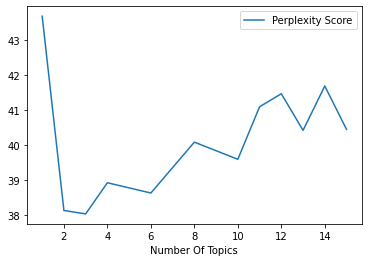

In [42]:
df_perplexity.plot.line("Number Of Topics", "Perplexity Score")

In [43]:
optimal_num_topics = 3

In [44]:
# define and fit LDA model

lda = sklearn.decomposition.LatentDirichletAllocation(
    n_components=optimal_num_topics,
    learning_method="online",
    random_state=0,
    n_jobs=-1
)
lda.fit(clean_vec1)

LatentDirichletAllocation(learning_method='online', n_components=3, n_jobs=-1,
                          random_state=0)

In [45]:
# output matrix
# h: docs to topics

lda_transform = lda.transform(clean_vec1)
#print(lda_transform.shape)
#print(lda_transform)

In [46]:
# output matrix
# w: words to topics

lda_components = lda.components_
#print(lda_components.shape)
#print(lda_components)

In [30]:
# define function to reformat output matrices into easily readable tables

def get_topics(mod, vec, names, docs, ndocs, nwords):
    # word to topic matrix
    W = mod.components_
    W_norm = W / W.sum(axis=1)[:, numpy.newaxis]
    # topic to document matrix
    H = mod.transform(vec)
    
    W_dict = {}
    H_dict = {}
    
    for tpc_idx, tpc_val in enumerate(W_norm):
        topic = "Topic{}".format(tpc_idx)
        
        # formatting w
        W_indices = tpc_val.argsort()[::-1][:nwords]
        W_names_values = [
            (round(tpc_val[j], 4), names[j]) 
            for j in W_indices
        ]
        W_dict[topic] = W_names_values
        
        # formatting h
        H_indices = H[:, tpc_idx].argsort()[::-1][:ndocs]
        H_names_values = [
            (round(H[:, tpc_idx][j], 4), docs[j]) 
            for j in H_indices
        ]
        H_dict[topic] = H_names_values
        
    W_df = pandas.DataFrame(
        W_dict, 
        index=["Word" + str(i) for i in range(nwords)]
    )
    H_df = pandas.DataFrame(
        H_dict,
        index=["Doc" + str(i) for i in range(ndocs)]
    )
        
    return (W_df, H_df)

In [31]:
# run function

W_df, H_df = get_topics(
    mod=lda,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=raw,
    ndocs=number_docs, 
    nwords=number_words
)

NameError: name 'raw' is not defined

In [32]:
# word-topic table
print(W_df)

NameError: name 'W_df' is not defined

In [33]:
# document-topic table
print(H_df)

NameError: name 'H_df' is not defined

### Visualizing LDA

In [47]:
# iterative visualization
# featuring pca biplot and histogram
lda_plot = pyLDAvis.sklearn.prepare(lda, clean_vec1, vectorizer1, R=10)
pyLDAvis.save_html(lda_plot, 'report/lda_desc.html')
pyLDAvis.display(lda_plot)

In [ ]:
# define functiont to fit and plot t-SNE model

def plot_tsne(data, threshold):
    # filter data according to threshold
    index_meet_threshold = numpy.amax(data, axis=1) >= threshold
    lda_transform_filt = data[index_meet_threshold]
    
    # fit tsne model
    # x-d -> 2-d, x = number of topics
    tsne = sklearn.manifold.TSNE(
        n_components=2, 
        verbose=0, 
        random_state=0, 
        angle=0.5, 
        init='pca'
    )
    tsne_fit = tsne.fit_transform(lda_transform_filt)
    
    # most probable topic for each headline
    most_prob_topic = []
    for i in range(tsne_fit.shape[0]):
        most_prob_topic.append(lda_transform_filt[i].argmax())
    
    print("LENGTH:\n{}\n".format(len(most_prob_topic)))

    unique, counts = numpy.unique(
        numpy.array(most_prob_topic), 
        return_counts=True
    )

    print("COUNTS:\n{}\n".format(numpy.asarray((unique, counts)).T))
    
    # make plot
    matplotlib.pyplot.figure(figsize=(10,6))
    #color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b', 'g', 'r']
    color_list = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

    for i in list(set(most_prob_topic)):
        indices = [idx for idx, val in enumerate(most_prob_topic) if val == i]
        matplotlib.pyplot.scatter(
            x=tsne_fit[indices, 0], 
            y=tsne_fit[indices, 1], 
            s=0.5, 
            c=color_list[i], 
            label='Topic' + str(i),
            alpha=1
        )
    
    
    matplotlib.pyplot.xlabel('x-tsne')
    matplotlib.pyplot.ylabel('y-tsne')
    matplotlib.pyplot.legend(markerscale=10)

In [ ]:
plot_tsne(data=lda_transform, threshold=0)

In [ ]:
# define and fit nmf model

nmf = sklearn.decomposition.NMF(
    n_components=optimal_num_topics,
    init="nndsvda",
    solver="mu",
    beta_loss="frobenius",
    random_state=0, 
    alpha=0.1, 
    l1_ratio=0.5
)
nmf.fit(clean_vec1)

In [ ]:
# run function to produce nice output tables

W_df, H_df = get_topics(
    mod=nmf,
    vec=clean_vec1,
    names=feature_names_vec1,
    docs=raw,
    ndocs=number_docs, 
    nwords=number_words
)

In [ ]:
# word-topic table
print(W_df)

In [ ]:
# document-topic table
print(H_df)

In [ ]:
# output raw document-topic matrix for t-SNE plot
nmf_transform = nmf.transform(clean_vec1)
print(nmf_transform.shape)
print(nmf_transform)

In [ ]:
# run function to produce t-SNE plot
plot_tsne(data=nmf_transform, threshold=0)